# Abstract

The film industry worldwide does upwards of 50 billion dollars in box office sales, not counting home entertainment revenue, which brings it up closer to 150 billion dollars. Operating within that brick of cash comes with a tremendous amount of risk, with films from major studios sometimes spending a quarter of a billion dollars or more on a single film. Decisions made at smaller studios are no less important to them, as they might be putting their entire livelihoods on the line in the hopes of a hit. And the value of a movie begins with a script.

My premise in creating this project was to ascertain whether a movie's critical rating can be determined to any extent by the text of its screenplay alone. Before attaching a cast and director and crew and all of the other costs associated with creating a cinematic work, having some guidance as to the quality of the script itself can be a benefit in minimizing risk. While an algorithm is no substitute for having a human eye on a screenplay, some level of unbiased machine learning can be leveraged to take a closer look. It is also possible to use this process to vet possible licensing if resources are short and slush piles are large.

As there are many factors going into a movie's rating, such as cast, director, editing, music, costuming, set design and so on, it is not necessarily expected that a movies critical rating can be determined solely by the text of its screenplay. However, there is still much value to be had if any measurable predictability can be found. At the completion of my modeling, I was ultimately able to predict scripts from good movies and bad movies, as rated by metacritic.com, about 65% of the time. Given the other factors in rating, I feel that is a significant enough to create value in the model. Among the various models I tried, some had a better true positive rate, and others had a better false positive rate, so there are some choices there depending on what use cases might be found, such as when it might be more advantageous to find a good movie versus avoiding a bad one.

Recommendations to a given filmmaker would be to use modeling to sort potential screenplays into lists of scripts with higher likelihood of success, using modeling to evaluate scripts in process and step back to consider if it needs more work if the model doesn't like it, and for the screenwriters themselves, to check their scripts against the model and if it comes back with a 'bad' rating, potentially rethink their life choices.

For further research, I would like to create a text ingestion field in the dashboard that allows a user to insert a body of text and have a prediction returned evaluating the content as a screenplay and assigning a good or bad designation. I would create predictability functionality that would allow a user to choose a 'good' or 'bad' setting and have automatically generated text returned back in the style of either a good or bad screenplay. And I would go deeper into the neural networds when modeling, especially toward regression. They showed promise when using them in this project, but there was insufficient time to build them out using pre-made embedding layers and so on.

# Imports

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd
import numpy as np
import importlib
import requests
import keras
import spacy
import time
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from bs4 import BeautifulSoup
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
from nltk import word_tokenize
from ast import literal_eval
from importlib import reload

# Importing my own functions file.
import functions as fun

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
tqdm_notebook.pandas()

In [4]:
nlp = spacy.load('en_core_web_sm')

# Obtaining Data

All data for this report will be gathered using web scraping from the following web sites:
    
- metacritic.com for movie rating information.
- rottontomatoes.com for additional movie rating information.
- SpringfieldSpringfield.co.uk for gathering the screenplay texts.

## Rating Data

There were a few attempts at scraping data before finding versions that worked well for my purposes. What follows are the final attempts.

### Sraping metacritic.com

I'm taking the most highly rated and most lowly rated films as listed on this site. These extremes will be used for training my classification models to pridict if random movies will be highly rated or lowly rated films.

#### Great Movies

In [6]:
goods_titles = []

for i in range(0,20):
    # There are 10 pages to flip through of 100 movies each.
    page = requests.get(
        'https://www.metacritic.com/browse/movies/score/metascore/all/filtered?page={}'.format(i),
        headers={'User-Agent': 'Chrome/80.0.3987.116'})
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Now that we've gotten the content from the page, we need to loop through each element.
    for i in range(0,100,1):
        title = soup.find_all('span', class_="title numbered")[i]\
            .next_sibling.next_sibling.contents[1].contents[0]
        goods_titles.append(title)
    
    # We're only pinging 10 times but might as well be safe since it costs like
    # nothing.
    time.sleep(1)

Knowing that I won't be able to come up with screenplays for every single movie, I'm taking 2000 great and 2000 terrible films, in the hopes of winding up with at least 1000 of each.

In [ ]:
len(goods_titles)

In [ ]:
goods_titles[:5]

#### Terrible Movies

In [ ]:
bads_titles = []

for i in range(110, 130):
    # There are 10 pages to flip through of 100 movies each.
    page = requests.get(
        'https://www.metacritic.com/browse/movies/score/metascore/all/filtered?page={}'.format(i),
        headers={'User-Agent': 'Chrome/80.0.3987.116'})
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Now that we've gotten the content from the page, we need to loop through each element.
    for i in range(0,100,1):
        try:
            title = soup.find_all('span', class_="title numbered")[i]\
            .next_sibling.next_sibling.contents[1].contents[0]
            bads_titles.append(title)
        except:
            pass
    # We're only pinging 10 times but might as well be safe since it costs like
    # nothing.
    time.sleep(1)

In [ ]:
len(bads_titles)

In [ ]:
goods_formatted = fun.format_titles(goods_titles)
bads_formatted = fun.format_titles(bads_titles)

### Scraping rottentomatoes.com

The rottentomatoes.com information will be used for linear regression. Whereas with metacritic we were using only the best and worst for classification, here I'm using samples from the entire spectrum for regression analysis.

In [ ]:
all_rotten_movies = []
rotten_scores = []
for i in range(0, 101):
    page = requests.get("https://www.rottentomatoes.com/browse/"
                        "dvd-streaming-all?minTomato={}&maxTomato={}&services"
                        "=amazon;hbo_go;itunes;netflix_iw;vudu;amazon_prime;"
                        "fandango_now&genres=1;2;4;5;6;8;9;10;11;13;18;14"
                        "&sortBy=release".format(i, i+1))
    soup = BeautifulSoup(page.content, 'html.parser')
    page = soup.get_text()
    comp = re.compile('"\/m\/\w+"')
    movies = comp.findall(page)
    movies_unique = list(set([movie[4:-1] for movie in movies]))
    rotten_scores.extend([i for _ in movies_unique])
    all_rotten_movies.extend(movies_unique)
    print(i)
    print(movies_unique)
    time.sleep(1)

In [ ]:
# Chopping off the year for those movies that have it.
rotten_movies_noyear = [film[:-5] if film[-4:-2] == '20' else film 
        for film in all_rotten_movies]

In [ ]:
rotten_form = fun.format_titles(rotten_movies_noyear)

## Scraping in the Screenplays

As this will be an analysis centered around natural language processing, my primary data source will be the screenplay text from every movie.

Unfortunately, I was eventually locked out of SpringfieldSpringfield.co.uk, the site where I retrieved the content from, due to too many 'visits'. As I had hit the site upwards of 10k times in the course of a few days, it was probably a fair call.

In [ ]:
# Getting the good screenplays along with a list of titles I couldn't find scripts for.
the_good, good_errors = fun.grab_screenplays(goods_formatted)

In [ ]:
len(good_errors)

In [ ]:
# Getting the good screenplays along with a list of titles I couldn't find scripts for.
the_bad, bad_errors = fun.grab_screenplays(bads_formatted)

In [ ]:
len(bad_errors)

Putting them both in a DataFrame to be used as data for the rest of the project.

In [ ]:
df_good = pd.DataFrame([the_good]).T
df_bad = pd.DataFrame([the_bad]).T

Now getting the screenplays for the rottentomatoes titles.

In [ ]:
rotten_movies, rotten_errors = fun.grab_screenplays(rotten_form)

In [ ]:
rotten_df = pd.DataFrame(columns=['titles',
                                  'titles_formatted',
                                  'rotten_scores',
                                  'scripts'])

In [ ]:
# Getting the titles and scores loaded into the DataFrame.
rotten_df.titles = rotten_form
rotten_df.RottenScores = rotten_scores

In [ ]:
# Getting things formatted correctly.
rotten_df.scripts = rotten_df.titles_formatted.apply(
    lambda x: rotten_scripts[0][x])

Loading all of this data into csv files to be saved in case of setbacks.

In [ ]:
df_good.to_csv('../project_resources/df_good_obtain.csv')
df_bad.to_csv('../project_resources/df_bad_obtain.csv')
rotten_df.to_csv('../project_resources/rotten_df_obtain.csv')

# Scrubbing Data

Reading back in data that was created in 'obtaining' file.

In [5]:
# I had intended to use files directly from the 'obtain' notebook to be cleaner,
# but I can't get back into the screenplay site, so I'll have to improvise.
# df_good = pd.read_csv('df_good_obtain.csv')
# df_bad = pd.read_csv('df_bad_obtain.csv')
# rotten_df = pd.read_csv('rotten_df_obtain.csv')

In [6]:
df_good = pd.read_csv('../project_resources/df_good.csv', index_col=False)
df_bad = pd.read_csv('../project_resources/df_bad.csv', index_col=False)
rotten_df = pd.read_csv('../project_resources/rotten_df.csv', index_col=0)

rotten_df.columns = ['titles', 'titles_formatted', 'rotten_scores', 
                     'scripts', 'all_together_now', 'no_stop', 'just_words']

## metacritic

### Setting up DataFrame

In [7]:
# Re-setting columns and index after re-importing.
df_good.columns = ['titles', 'scripts', 'good_or_bad']
df_bad.columns = ['titles', 'scripts', 'good_or_bad']

# Adding labels, combining good and bad, and dropping missing scripts.
df_good['good_or_bad'] = 1
df_bad['good_or_bad'] = 0

screenplays = pd.concat([df_good, df_bad])
screenplays.columns = ['titles', 'scripts', 'good_or_bad']

screenplays.dropna(inplace=True)

In [8]:
print('# of good screeenplays: ', len(screenplays[screenplays['good_or_bad'] == 1]))
print('# of bad screenplays: ', len(screenplays[screenplays['good_or_bad'] == 0]))

# of good screeenplays:  1270
# of bad screenplays:  1514


In [9]:
# converting imported screenplays back to lists from strings
screenplays.scripts = screenplays.scripts.apply(literal_eval)

# Series with a list of lines for each screenplay.
good_to_count = screenplays[screenplays['good_or_bad'] == 1]
bad_to_count = screenplays[screenplays['good_or_bad'] == 0]

# Single string of all good words.
splice_scripts = ''
for script in good_to_count['scripts']:
    splice_scripts += ''.join(script)

all_good_words = ''.join(splice_scripts)

# Single string of all bad words.
splice_scripts = ''
for script in bad_to_count['scripts']:
    splice_scripts += ''.join(script)

all_bad_words = ''.join(splice_scripts)

# Lists of all words lumped together and tokenized
good_data = word_tokenize(all_good_words)
bad_data = word_tokenize(all_bad_words)

### Script Metrics

Creating some simple word metrics.

In [126]:
print('good words total: ', len(good_data))
print('bad words total: ', len(bad_data))
print('----'*20)

print('good vocabulary: ', len(set(good_data)))
print('bad vocabulary: ', len(set(bad_data)))
print('----'*20)

print('good % vocab to total: ', round(len(set(good_data)) / len(good_data),4))
print('bad % vocab to total: ', round(len(set(bad_data)) / len(bad_data),4))
print('----'*20)

# Total words divided by total number of sripts.
print('Average Good # Words: ', len(good_data) / len(good_to_count))
print('Average Bad # Words: ', len(bad_data) / len(bad_to_count))
print('----'*20)

print('Ave difference by words, good vs bad: ', 
      round(((len(good_data) / len(good_to_count)) \
       - (len(bad_data) / len(bad_to_count))) / (len(bad_data) \
                                                 / len(bad_to_count)),2))
print('----'*20)

good words total:  14020073
bad words total:  15477699
--------------------------------------------------------------------------------
good vocabulary:  172220
bad vocabulary:  183840
--------------------------------------------------------------------------------
good % vocab to total:  0.0123
bad % vocab to total:  0.0119
--------------------------------------------------------------------------------
Average Good # Words:  11039.427559055119
Average Bad # Words:  10223.050858652576
--------------------------------------------------------------------------------
Ave difference by words, good vs bad:  0.08
--------------------------------------------------------------------------------


Counting punctuation and comparing good to bad.

In [11]:
for p in [':', ';', ',', '...', '!']:
    good_p = good_data.count(p) / len(good_data)
    bad_p = bad_data.count(p) / len(bad_data)
    print(f'Good \'{p}\' ratio: ', np.format_float_positional(round(good_p, 6)))
    print(f'Bad \'{p}\' ratio: ', np.format_float_positional(round(bad_p,6)))
    print(f'Good-Bad % for \'{p}\'', round((good_p - bad_p) / bad_p,2))
    print('-----'*10)

Good ':' ratio:  0.001625
Bad ':' ratio:  0.001428
Good-Bad % for ':' 0.14
--------------------------------------------------
Good ';' ratio:  0.000048
Bad ';' ratio:  0.000114
Good-Bad % for ';' -0.58
--------------------------------------------------
Good ',' ratio:  0.047181
Bad ',' ratio:  0.048443
Good-Bad % for ',' -0.03
--------------------------------------------------
Good '...' ratio:  0.011329
Bad '...' ratio:  0.010441
Good-Bad % for '...' 0.09
--------------------------------------------------
Good '!' ratio:  0.010268
Bad '!' ratio:  0.014268
Good-Bad % for '!' -0.28
--------------------------------------------------


Bad scripts on average use 28% more exclamation marks and 58% more semicolons.

Now creating additional columns for scripts in different formats. Right now, each script line is an element of a list. Breaking those apart into one long string.

In [12]:
splice_scripts = ''
for script in screenplays['scripts']:
    splice_scripts += ''.join(script)

all_words = ''.join(splice_scripts)

temp = []
for script in screenplays['scripts']:
    temp.append(''.join(script))

# This has each script as one long string inside of its cell, 
# as opposed with a list of lines.
screenplays['all_together_now'] = temp

data = word_tokenize(all_words)

Looking for # of unique tokens so I know roughly how many to play with when modeling.

In [13]:
len(set(data))

278462

The below function will be used in an apply function remove the stop words for purposes further down. One will keep punctuation and one will remove it.

In [14]:
screenplays['no_stop'] = screenplays['all_together_now']\
    .progress_apply(fun.stop_it, punct=False)

screenplays['just_words'] = screenplays['all_together_now']\
    .progress_apply(fun.stop_it, punct=True)

## Rottentomatoes

### Setting up DataFrame

In [15]:
rotten_df.dropna(inplace=True)

In [16]:
temp = []
for script in rotten_df.scripts:
    temp.append(''.join(script))

In [17]:
# This has each script as one long string inside of its cell, 
# as opposed with a list of lines.
rotten_df['all_together_now'] = temp

Using this function again for rotten_df this time to remove stop words for one columns of scripts and remove stop words plus punctuation for another.

In [18]:
rotten_df['no_stop'] = rotten_df['all_together_now']\
    .progress_apply(fun.stop_it, punct=False)

rotten_df['just_words'] = rotten_df['all_together_now']\
    .progress_apply(fun.stop_it, punct=True)

In [19]:
# Need to rename the period since it causes problems later on.
rotten_df.rename(columns={'.':'PER'}, inplace=True)

In [20]:
# rotten_df.dropna(inplace=True)
# screenplays.dropna(inplace=True)

rotten_df = rotten_df.drop_duplicates(subset=['titles']).copy()
screenplays = screenplays.drop_duplicates(['titles']).copy()

screenplays.to_csv('../project_resources/screenplays_scrub.csv')
rotten_df.to_csv('../project_resources/rotten_df_scrub.csv')

# Exploratory Data Analysis

## Local Functions

In [21]:
# Counting punctuation and parts of speech
def count_punct(text, punk):
    return text.count(punk) / len(text.split())

def count_pos(x):
    return x.count_by(spacy.attrs.POS)

def count_tag(x):
    return x.count_by(spacy.attrs.TAG)

# Determining the average sentence length for a given script.
def sent_len(str):
    doc = nlp(str)
    count = 0
    
    for sent in doc.sents:
        count += 1
    
    return len(str.split()) / count

# These two find the acutal POS name for the code number supplied, for
# creating the column names.
def POS_reverse_lookup_n_ratio(x, code):
    try:
        return x.POS_counts[code] / x.word_count
    except:
        pass

def TAG_reverse_lookup_n_ratio(x, code):
    try:
        return x.TAG_counts[code] / x.word_count
    except:
        return 0

## Bringing in the data

Reading back in data we scubbed in 'scrubbing'. 

In [22]:
# screenplays = pd.read_csv('../project_resources/screenplays_scrub.csv', index_col=0)
# rotten_df = pd.read_csv('../project_resources/rotten_df_scrub.csv', index_col=0)

screenplays.dropna(inplace=True)

In [23]:
# Adding column showing if a title is above or below a score of 50.
rotten_df['good_or_bad'] = rotten_df.rotten_scores.apply(
    lambda x: 1 if x >=50 else 0)

# Re-ordering columns to line up the two data sources for later use.
screen_cols = list(screenplays.columns)
screen_cols.remove('good_or_bad')
screen_cols.append('good_or_bad')
screenplays = screenplays[screen_cols].copy()

rotten_cols = list(rotten_df.columns)
rotten_cols.remove('rotten_scores')
rotten_cols.append('rotten_scores')
rotten_df = rotten_df[rotten_cols].copy()
rotten_df.drop('titles', axis=1, inplace=True)

In [24]:
# rotten_df = rotten_df[sort_cols]
rotten_df.rename(columns={'titles_formatted':'titles'}, inplace=True)

## Latent Derichlet Allocation

Finding the categories inherent in the screenplays by analyzing the words and grouping the screenplays.

In [25]:
combined_df = pd.concat([rotten_df[['titles', 'just_words']],
                         screenplays[['titles', 'just_words']]],
                         ignore_index=True)

combined_df.drop_duplicates(subset='titles', inplace=True)

In [26]:
cv = CountVectorizer(min_df=.1, max_df=.6)
victor = cv.fit_transform(combined_df.just_words)
LDA = LatentDirichletAllocation(n_components=10, random_state=42)
combined_df['category'] = LDA.fit_transform(victor).argmax(axis=1)

Showing the category word groupings, then creating materiels to be used later.

In [27]:
# This will house the dictionaries for using in the dashboard.
cat_word_dicts = []

# Priting out the word gropuings and filling in the cat_word_dicts list.
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR CATEGORY #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')
    cat_word_dicts.append({index:[cv.get_feature_names()[i]\
                                  for i in topic.argsort()[-15:]]})
#     cat_word_dicts.append([cv.get_feature_names()[i]\
#                           for i in topic.argsort()[-15:]])

cat_word_df = pd.DataFrame()

# Creating a dataframe for export to .csv for later use.
for i in range(len(cat_word_dicts)):
    cat_word_df[i] = cat_word_dicts[i][i]

# Creating category mapping for all dataframes to indicate how I see 
# The groupings. This part is just based on my looking them over.
category_map = {0: 'Dark & Political', 1: 'Sports, Comedy, Silly Horror', 
                2: 'Conflict', 3: 'Holiday, Films I Haven\'t Seen',
                4: 'Light-Hearted', 5: 'Unusual Language or Slang', 
                6: 'Violence & Gangster', 7: 'Romance & Light Drama', 
                8: 'Life Stories', 9: 'Straight Up Horror'}
combined_df['category_label'] = combined_df.category.map(category_map)

THE TOP 15 WORDS FOR CATEGORY #0
['government', 'fight', 'human', 'war', 'law', 'body', 'children', 'power', 'court', 'country', 'state', 'president', 'death', 'police', 'dr']


THE TOP 15 WORDS FOR CATEGORY #1
['buddy', 'wow', 'team', 'cool', 'uh', 'ball', 'aint', 'ya', 'ah', 'em', 'dog', 'ha', 'game', 'whoa', 'ok']


THE TOP 15 WORDS FOR CATEGORY #2
['air', 'safe', 'jim', 'ship', 'war', 'jack', 'officer', 'clear', 'shot', 'shoot', 'fire', 'police', 'john', 'captain', 'gun']


THE TOP 15 WORDS FOR CATEGORY #3
['ooh', 'whoa', 'ah', 'christmas', 'cool', 'wow', 'bye', 'daddy', 'charlie', 'sam', 'honey', 'jack', 'um', 'uh', 'mom']


THE TOP 15 WORDS FOR CATEGORY #4
['uh', 'grunts', 'radio', 'crowd', 'chatter', 'cheering', 'speaking', 'indistinct', 'continues', 'laughs', 'playing', 'laughing', 'sighs', 'chuckles', 'music']


THE TOP 15 WORDS FOR CATEGORY #5
['aint', 'poor', 'sister', 'darling', 'war', 'brother', 'child', 'death', 'lady', 'children', 'king', 'lord', 'dear', 'shall', 'mrs']


I'm going to need the combined dataframes with LDA categories for the dashboard later on.

In [28]:
screenplays = pd.merge(screenplays, combined_df[['titles','category', 'category_label']],
                how='left', on='titles')

rotten_df = pd.merge(rotten_df, combined_df[['titles','category', 'category_label']],
                how='left', on='titles')

cat_word_df.to_csv('../project_resources/cat_word_df.csv', header=True)

combined_df.to_csv('../project_resources/combined_df.csv')

## Metacritic

### Feature Engineering

Will be creating quite a few new columns filled with script attributes such as word counts, sentiment, and parts of speech.

Putting in some counts.

In [29]:
screenplays['word_count'] = screenplays.all_together_now.apply(
    lambda x: len(x.split()))
screenplays['unique_words'] = screenplays.no_stop.apply(
    lambda x: len(x.split()))

Creating columns for sentiment scoring: positive, negative, neutral, and compound.

In [30]:
sid = SentimentIntensityAnalyzer()

screenplays['sentiment_scores'] = screenplays.no_stop.progress_apply(
    lambda x: sid.polarity_scores(x))

screenplays['sentiment_negative'] = screenplays.sentiment_scores.apply(
    lambda x: x['neg'])
screenplays['sentiment_neutral'] = screenplays.sentiment_scores.apply(
    lambda x: x['neu'])
screenplays['sentiment_positive'] = screenplays.sentiment_scores.apply(
    lambda x: x['pos'])
screenplays['sentiment_compound'] = screenplays.sentiment_scores.apply(
    lambda x: x['compound'])

Removing anything with fewer words words so that short scripts don't throw off the modeling.

In [31]:
screenplays_cut = screenplays.copy().drop(
    index=(screenplays[screenplays['word_count'] < 1000].index), axis=0)

More columns for punctuation ratios.

In [32]:
screenplays_cut['colon_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ':'))
screenplays_cut['semi_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ';'))
screenplays_cut['comma_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ','))
screenplays_cut['ellipsis_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, '...'))

And sentence length.

In [33]:
screenplays_cut['sentence_length'] = screenplays_cut.no_stop.progress_apply(
    sent_len)

### Parts of Speech

Breaking out both coarse and fine grained approaches to parts of speech, to create a ratio of how many of each is used in each screenplay.

In [34]:
screenplays_cut['nlp'] = screenplays_cut.all_together_now.progress_apply(nlp)
screenplays_cut.to_csv('../project_resources/screenplays_cut.csv')

In [35]:
# Applying the 'progress_apply' function to each row to get the actual words.
screenplays_cut['POS_counts'] = screenplays_cut.nlp.progress_apply(count_pos)
screenplays_cut['TAG_counts'] = screenplays_cut.nlp.progress_apply(count_tag)

# POS_codes and TAG codes will be used to identify unique codes 
# used throughout vocabulary.
POS_codes = set()

for i, item in enumerate(screenplays_cut.POS_counts):
    POS_codes.update(item.keys())

TAG_codes = set()

for i, item in enumerate(screenplays_cut.TAG_counts):
    TAG_codes.update(item.keys())

In [36]:
all_scripts = set()

for i, script in enumerate(screenplays_cut.just_words):
    all_scripts.update(script.split())

all_scripts = [script for script in all_scripts]

all_scripts = ' '.join(all_scripts)

all_scripts = nlp(all_scripts[:30])

Adding POS columns.

In [37]:
# TAG_lookup will be used for adding POS word to column name.
TAG_lookup = {}
for code in TAG_codes:
    key = code
    value = all_scripts.vocab[code].text
    TAG_lookup[key] = value

POS_lookup = {}
for code in POS_codes:
    key = code
    value = all_scripts.vocab[code].text
    POS_lookup[key] = value

# Adding POS column and adding POS name as column name.
for code, abb in POS_lookup.items():
    screenplays_cut[abb] = screenplays_cut.apply(
        POS_reverse_lookup_n_ratio, args=[code], axis=1)

# Adding TAG column and adding TAG name as column name.
for code, abb in TAG_lookup.items():
    screenplays_cut[abb] = screenplays_cut.apply(
        TAG_reverse_lookup_n_ratio, args=[code], axis=1)

In [38]:
screenplays_cut = screenplays_cut.fillna(0)

screenplays_cut.to_csv('../project_resources/screenplays_cut.csv')

## Rottentomatoes

### Feature Engineering

As with metacritic, will be creating quite a few new columns filled with script attributes such as word counts, sentiment, and parts of speech.

Putting in some counts.

In [39]:
rotten_df['word_count'] = rotten_df.all_together_now.apply(
    lambda x: len(x.split()))
rotten_df['unique_words'] = rotten_df.no_stop.apply(
    lambda x: len(x.split()))

In [40]:
rotten_df_cut = rotten_df.copy().drop(
    index=(rotten_df[rotten_df['word_count'] < 1000].index), axis=0)

Creating columns for sentiment scoring: positive, negative, neutral, and compound.

In [41]:
sid = SentimentIntensityAnalyzer()

rotten_df_cut['sentiment_scores'] = rotten_df.no_stop.progress_apply(
    lambda x: sid.polarity_scores(x))

rotten_df_cut['sentiment_negative'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['neg'])
rotten_df_cut['sentiment_neutral'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['neu'])
rotten_df_cut['sentiment_positive'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['pos'])
rotten_df_cut['sentiment_compound'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['compound'])

Removing anything with fewer words words so that short scripts don't throw off the modeling.

More columns for punctuation ratios.

In [42]:
rotten_df_cut['colon_ratios'] = rotten_df_cut.no_stop.apply(
    lambda x: count_punct(x, ':'))
rotten_df_cut['semi_ratios'] = rotten_df_cut.no_stop.apply(
    lambda x: count_punct(x, ';'))
rotten_df_cut['comma_ratios'] = rotten_df_cut.no_stop.apply(
    lambda x: count_punct(x, ','))
rotten_df_cut['ellipsis_ratios'] = rotten_df_cut.no_stop.apply(
    lambda x: count_punct(x, '...'))

And sentence length.

In [43]:
rotten_df_cut['sentence_length'] = rotten_df_cut.no_stop.progress_apply(
    sent_len)

### Parts of Speech

Breaking out both coarse and fine grained approaches to parts of speech, to create a ratio of how many of each is used in each screenplay.

In [44]:
rotten_df_cut['nlp'] = rotten_df_cut.all_together_now.progress_apply(nlp)

In [45]:
rotten_df_cut.to_csv('../project_resources/rotten_df_cut.csv')

In [46]:
# rotten_df_cut = pd.read_csv('../project_resources/rotten_df_cut.csv')

In [47]:
# Applying the 'progress_apply' function to each row to get the actual words.
rotten_df_cut['POS_counts'] = rotten_df_cut.nlp.progress_apply(count_pos)

rotten_df_cut['TAG_counts'] = rotten_df_cut.nlp.progress_apply(count_tag)

# POS_codes and TAG codes will be used to identify unique codes 
# used throughout vocabulary.
POS_codes = set()

for i, item in enumerate(rotten_df_cut.POS_counts):
    POS_codes.update(item.keys())

TAG_codes = set()

for i, item in enumerate(rotten_df_cut.TAG_counts):
    TAG_codes.update(item.keys())

Adding POS columns.

In [48]:
# TAG_lookup will be used for adding POS word to column name.
TAG_lookup = {}
for code in TAG_codes:
    key = code
    value = all_scripts.vocab[code].text
    TAG_lookup[key] = value
    
POS_lookup = {}
for code in POS_codes:
    key = code
    value = all_scripts.vocab[code].text
    POS_lookup[key] = value

# Adding POS column and adding POS name as column name.
for code, abb in POS_lookup.items():
    rotten_df_cut[abb] = rotten_df_cut.apply(
        POS_reverse_lookup_n_ratio, args=[code], axis=1)

# Adding TAG column and adding TAG name as column name.
for code, abb in TAG_lookup.items():
    rotten_df_cut[abb] = rotten_df_cut.apply(
        TAG_reverse_lookup_n_ratio, args=[code], axis=1)

In [49]:
rotten_df_cut = rotten_df_cut.fillna(0)

In [50]:
rotten_df_cut.to_csv('../project_resources/rotten_df_cut.csv')

Note that in the original eda.ipynb file, I have an extensive set of scatter matrices, histograms, and correlation matrices at this point in the process. However, they took up too much memory to be efficiently placed in this document, but they can be referred to in eda.ipynb as needed.

# Classification Modeling

## Bring in the data

Data previously saved in .csv format from eda.ipynb.

In [51]:
# rotten_df_cut = pd.read_csv('../project_resources/rotten_df_cut.csv', index_col=0)
# screenplays_cut = pd.read_csv('../project_resources/screenplays_cut.csv', index_col=0)

Shuffling columns  for ease of use when modeling.

In [52]:
screen_cols = list(screenplays_cut.columns)
screen_cols.remove('good_or_bad')
screen_cols.append('good_or_bad')
screenplays_model = screenplays_cut[screen_cols].copy()

rotten_cols = list(rotten_df_cut.columns)
rotten_cols.remove('good_or_bad')
rotten_cols.append('good_or_bad')
rotten_cols.remove('rotten_scores')
rotten_cols.append('rotten_scores')
rotten_model = rotten_df_cut[rotten_cols].copy()

In [53]:
# sort_cols = list(rotten_model.columns[:38])
# sort_cols.extend(sorted(list(rotten_model.columns[38:-2])))
# sort_cols.extend(list(rotten_model.columns[-2:]))

## TFIDF Vectorization

My first set of models will employ TFIDF Vectorization using a variety of classifiers.m

### Setup

For the modeling, I'm going to use the extreme ratings I got from metacritic.com for training the models, then use the rottentomatoes data, which is uniformly distributed from bad movies to good movies, to test the modeling.

In [54]:
X_train = screenplays_cut.no_stop
X_test = rotten_df_cut.no_stop

y_train = screenplays_cut.good_or_bad
y_test = rotten_df_cut.good_or_bad

### Linear SVC

              precision    recall  f1-score   support

           0       0.64      0.77      0.70       811
           1       0.67      0.52      0.58       719

    accuracy                           0.65      1530
   macro avg       0.65      0.64      0.64      1530
weighted avg       0.65      0.65      0.65      1530



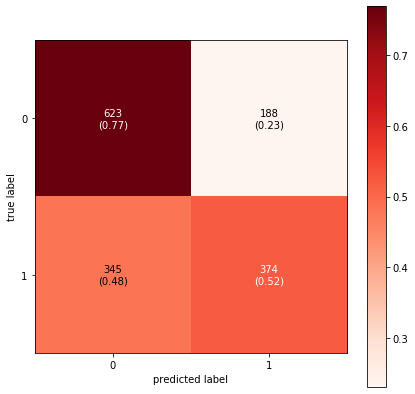

roc_auc score:  0.7007249073500837


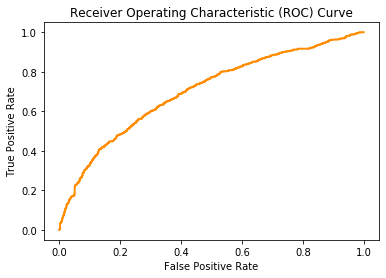

array([0, 0, 1, ..., 1, 0, 0])

In [55]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, LinearSVC())

### SVC

              precision    recall  f1-score   support

           0       0.65      0.77      0.71       811
           1       0.67      0.54      0.60       719

    accuracy                           0.66      1530
   macro avg       0.66      0.65      0.65      1530
weighted avg       0.66      0.66      0.66      1530



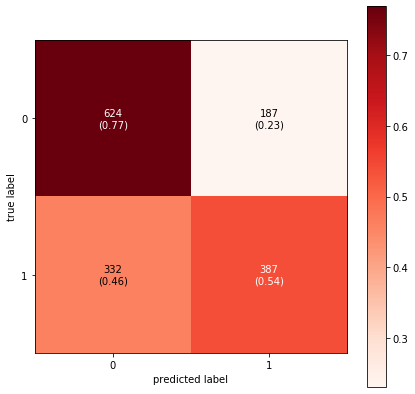

roc_auc score:  0.714379301297013


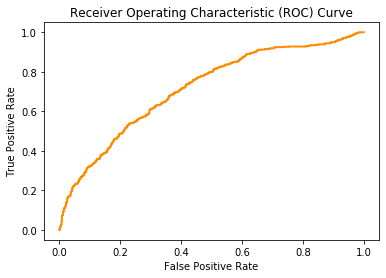

array([0, 0, 1, ..., 1, 1, 0])

In [56]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, SVC())

### XGBoost Classifier

              precision    recall  f1-score   support

           0       0.65      0.80      0.72       811
           1       0.69      0.52      0.59       719

    accuracy                           0.67      1530
   macro avg       0.67      0.66      0.66      1530
weighted avg       0.67      0.67      0.66      1530



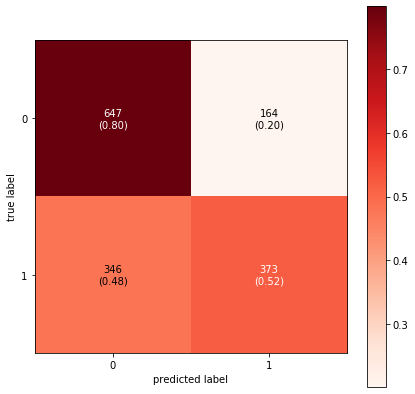

array([0, 0, 0, ..., 1, 1, 0])

In [57]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, 
                   XGBClassifier(max_depth=8,
                                    criterion='entropy',
                                    min_samples_split=14,
                                    min_samples_leaf=1,
                                    max_features=160))

### Neural Network

Because the neural network works so differently from the other classifiers, I haven't used a function, and the main code is all here.

Starting to put the data together.

In [128]:
X_train = pd.DataFrame(X_train)

# Undersampling to get things even just for ease of use.
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

X_resampled = X_resampled.iloc[:, 0]

Create the vector from the full batch of scripts.

In [129]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.95, min_df=.1, 
                        ngram_range=(1,2))
X_t_train = tfidf.fit_transform(X_resampled)
X_t_test = tfidf.transform(X_test)

AttributeError: 'numpy.float64' object has no attribute 'lower'

Getting the data into the format it will need to be in for the network.

In [ ]:
X_t_train = pd.SparseDataFrame(X_t_train, columns=tfidf.get_feature_names(),
                           default_fill_value=0)
X_t_test = pd.SparseDataFrame(X_t_test, columns=tfidf.get_feature_names(),
                           default_fill_value=0)

X_t_num = np.array(X_t_train)
X_t_test_num = np.array(X_t_test)

y_t_num = np.array(y_resampled)
y_t_test_num = np.array(y_test)

layer_input = X_t_train.shape[1]

I played manually with a lot of different layers, neurons, drop layers, and regularization. Simple seemed to work best.

In [ ]:
model = Sequential()

model.add(Dense(layer_input, input_dim=layer_input, activation='relu'))
model.add(Dense(50, input_dim=layer_input, activation='relu'))
model.add(Dense(50, input_dim=50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='mean_squared_error',
              optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_t_num, y_t_num, epochs=10, batch_size=50, validation_split=0.2)

In [ ]:
# y_t_test = y_test

In [ ]:
model.evaluate(X_t_test_num, y_t_test_num, verbose=1)

In [ ]:
y_pred = model.predict_classes(X_t_test_num)

print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                  show_normed=True, cmap=plt.cm.Reds);
plt.show();

Overall, a pretty positive model.

### TFIDF Summary

The models here were strong, overall. Most of them had accuracy of around 65%, with poor true positive rate of around 50, which means they were quite good at predicting which scripts were bad but not great at predicting which scripts were good. The decision tree had good true positive rate at 61%, but the accuracy wasn't as good at 58%. XG Boost had the best accuracy at 66, but the true positive rate of precisely 50%, with true negative rate 80%.

## Script Attributes

>Add notes about attributes

### Setup

For this set of modeling, I'm using only the script attributes from the dataframe, so basically word counts, punctuation ratios, sentence length, sentiment, and parts of speech.

In [66]:
screen_dummies = pd.get_dummies(screenplays_model['category'])
rotten_dummies = pd.get_dummies(rotten_model['category'])

In [67]:
columns = list(screenplays_model.columns[7:9])
columns.extend(list(screenplays_model.columns[10:19]))
start = list(screenplays_model.columns).index('PROPN')
columns.extend(list(screenplays_model.columns[start:-1]))
    
X = screenplays_model[columns]
X_train = pd.merge(screenplays_model[columns], screen_dummies, left_index=True, 
             right_index=True)
X_test = pd.merge(rotten_model[columns], rotten_dummies, left_index=True, 
             right_index=True)

y_train = screenplays_model.good_or_bad
y_test = rotten_model.good_or_bad

### XG Boost Classifier

              precision    recall  f1-score   support

           0       0.59      0.43      0.50       811
           1       0.51      0.66      0.57       719

    accuracy                           0.54      1530
   macro avg       0.55      0.54      0.54      1530
weighted avg       0.55      0.54      0.53      1530



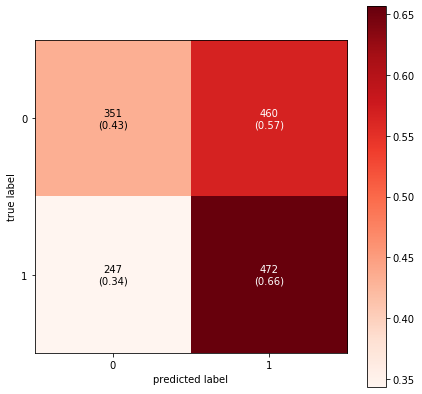

array([0, 0, 1, ..., 1, 1, 0])

In [68]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, 
                   classifier=XGBClassifier(),use_tfidf=False)

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.60      0.42      0.49       811
           1       0.51      0.69      0.59       719

    accuracy                           0.55      1530
   macro avg       0.56      0.55      0.54      1530
weighted avg       0.56      0.55      0.54      1530



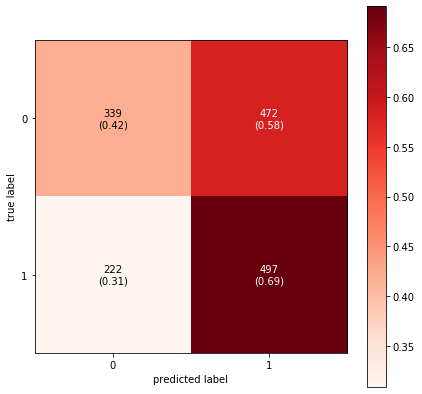

array([0, 1, 1, ..., 0, 1, 0])

In [69]:
fun.hybrid_classifiers(X_train, X_test, y_train, y_test, 
                   classifier=RandomForestClassifier(random_state=42,
                                                    max_depth=8,
                                                    criterion='entropy',
                                                    min_samples_split=14,
                                                    min_samples_leaf=1,
#                                                     max_features=10),
                                                    ),
                  use_tfidf=False)

### Scripts Attributes Summary

This set was much lower than the TFIDF, with scores that were only a little above random chance. The neural network simply classified everything as positive. I'm sure I could have done something to improve this batch given time, but for now, as it was so much lower than the TFIDF set, I chose to let it go.

## Combined TDIF & Attributes

### Setup

For this more experimental bunch, I thought I would try merging the TFIDF vecctorization matrix with the attributes from the original dataframe, wondering if more information might be better, and how the engineered features might play against the word matrix.

In [70]:
screen_dummies = pd.get_dummies(screenplays_model['category'])
rotten_dummies = pd.get_dummies(rotten_model['category'])

In [71]:
columns = list(screenplays_model.columns[7:9])
columns.extend(list(screenplays_model.columns[10:19]))
start = list(screenplays_model.columns).index('PROPN')
columns.extend(list(screenplays_model.columns[start:-1]))

X_train = screenplays_model[columns].copy()
X_test = rotten_model[columns].copy()

y_train = screenplays_model.good_or_bad.copy()
y_test = rotten_model.good_or_bad.copy()

In [72]:
X2_train = screenplays_model.no_stop
X2_test = rotten_model.no_stop
y_train = screenplays_model.good_or_bad
y_test = rotten_model.good_or_bad

### Linear Support Vector Classifier

In [73]:
# temp = pd.DataFrame(X2_train, columns=['temp'])
# temp[temp['temp'].isna() == True].index

In [74]:
# screenplays_model.iloc[[40, 69, 101, 106, 147, 175, 264, 303, 343, 371, 392,
#              464, 656, 811, 963, 1099, 2024, 2044, 2066, 2265, 2554, 2600]]

//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



              precision    recall  f1-score   support

           0       0.25      0.00      0.00       811
           1       0.47      1.00      0.64       719

    accuracy                           0.47      1530
   macro avg       0.36      0.50      0.32      1530
weighted avg       0.35      0.47      0.30      1530

Accuracy:  0.46862745098039216


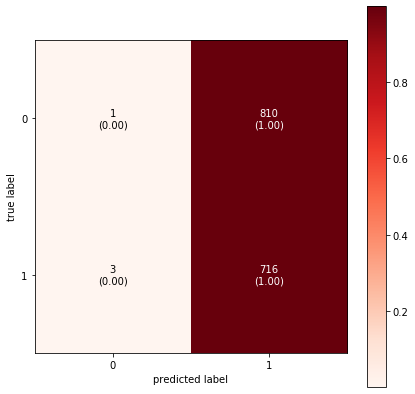

roc_auc score:  0.5150820858535883


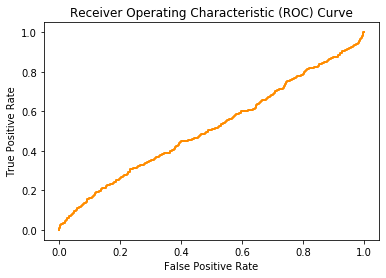

In [75]:
fun.hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                        y_train, y_test, LinearSVC(C=.6))

### Logistic Regression Classifier

              precision    recall  f1-score   support

           0       0.53      0.99      0.69       811
           1       0.61      0.02      0.04       719

    accuracy                           0.53      1530
   macro avg       0.57      0.50      0.36      1530
weighted avg       0.57      0.53      0.38      1530

Accuracy:  0.5333333333333333


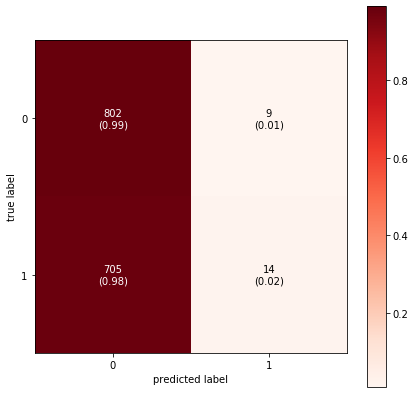

roc_auc score:  0.498411103241418


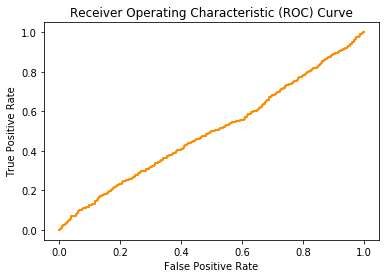

In [76]:
fun.hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                        y_train, y_test, LogisticRegression(C=10))

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       811
           1       0.67      0.55      0.60       719

    accuracy                           0.66      1530
   macro avg       0.66      0.65      0.65      1530
weighted avg       0.66      0.66      0.65      1530

Accuracy:  0.6588235294117647


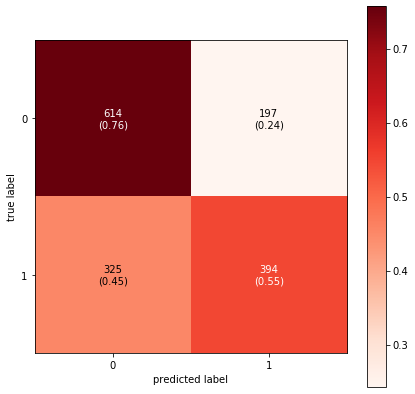

In [77]:
fun.hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                        y_train, y_test, 
                        RandomForestClassifier(random_state=42, 
                                               n_jobs=-1),
                        feature_importance=False)

## Stacked Modeling

This is one of my top models from the TFIDF modeling section. I'll use it as the first phase of a two-part modeling scenario.

First, I'm going to send in the movies from metacritic to train the first model, using the rottentomatoes data for testing. Then I'll marry the test predictions to the rottentomatoes (test) data, and send it through the second model, where it will get split into a proper train-test split.

In [78]:
X_train = screenplays_cut.no_stop
X_test = rotten_df_cut.no_stop

y_train = screenplays_cut.good_or_bad
y_test = rotten_df_cut.good_or_bad

              precision    recall  f1-score   support

           0       0.65      0.77      0.71       811
           1       0.67      0.54      0.60       719

    accuracy                           0.66      1530
   macro avg       0.66      0.65      0.65      1530
weighted avg       0.66      0.66      0.66      1530



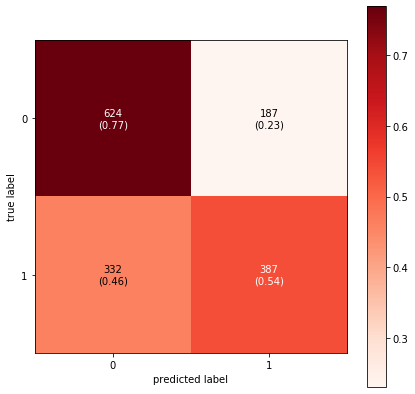

roc_auc score:  0.714379301297013


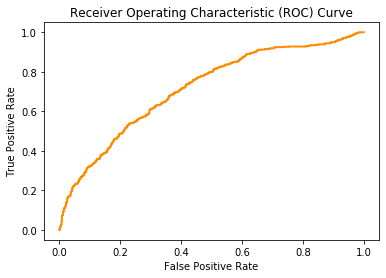

In [79]:
model_1_predictions = fun.hybrid_classifiers(X_train, X_test, y_train, y_test, SVC())

In [80]:
# X = screenplays_model.no_stop
# y = screenplays_model.good_or_bad

# model_1_predictions = fun.stacked_classifier(X, y, SVC())

Below I'm getting the dummies and putting them all in one dataframe to be joined later.

In [81]:
screen_dummies = pd.get_dummies(screenplays_model['category'])
rotten_dummies = pd.get_dummies(rotten_model['category'])

In [82]:
# columns = ['sentiment_neutral', 'sentence_length', 'PRON', 'CCONJ', 'PUNCT', 'NNS',
#  '_SP', 'VBD', 'WDT', 'VB', 'PRP', 'RP', 'PRP$', 'CC', '.', 'IN', '-RRB-',
#  'VBP', 'WP', 'HYPH']

columns = ['word_count', 'unique_words']
columns.extend(rotten_model.columns[10:19])
columns.extend(rotten_model.columns[23:-2])

X = pd.merge(rotten_model[columns].copy(), rotten_dummies, left_index=True, 
             right_index=True)

y = rotten_model.good_or_bad.copy()

In [83]:
X['predictions'] = model_1_predictions

Using the test data from previously, since it had not yet seen the overfit training model.

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       152
           1       0.70      0.64      0.67       154

    accuracy                           0.68       306
   macro avg       0.68      0.68      0.68       306
weighted avg       0.68      0.68      0.68       306



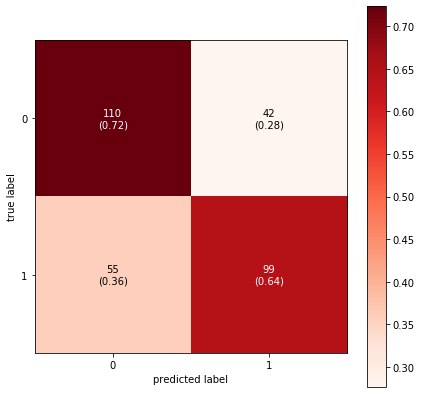

In [84]:
fun.script_classifiers(X, y,
                   classifier=RandomForestClassifier(random_state=42,
                                                    max_depth=9,
                                                    criterion='entropy',
                                                    min_samples_split=14,
                                                    min_samples_leaf=1,
                                                    n_estimators=103),
                      use_tfidf=False, test_size=.2)

## Classification Summary

This turned out to be my best model: SVC using TFIDF, then take the predictions from that, add them as a feature (to test data that has not been modeled) and run that data again through a random forest classifier: 68% accuracy, with a true positive rate of 64% and a true negative rate of 72%. Besides having the greatest accuracy, this model also turned out to be the most balanced.

# Linear Regression Modeling

Next I attempted some regression models using data from rottontomatoes.

The models here are only the ones I kept. The others had results that were basically no better than chance.

### TFIDF with XGBoost Regressor

I grid searched the hell out of this one, only to find that none of it mattered. So I removed the grid search function.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(rotten_model.no_stop,
                                                    rotten_model.rotten_scores,
                                                    test_size=.3,
                                                    random_state=42)

tfidf = TfidfVectorizer(max_features=5000, max_df=.9, min_df=.1, 
                        ngram_range=(1,2))
word_predictors = tfidf.fit_transform(X_train)
word_test = tfidf.transform(X_test)

model = XGBRegressor(random_state=42, n_estimators=100, 
                     objective='reg:squarederror')
model.fit(word_predictors, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

r^2 and mse for train and test.

In [86]:
def get_regression_scores(X_train, X_test, y_train_y_test, model):
    y_hat_train = model.predict(word_predictors)
    y_hat_test = model.predict(word_test)
    print('train MSE score: ', mse(y_train, y_hat_train))
    print('train r2_score: ', r2_score(y_train, y_hat_train))
    print('Test MSE score:', mse(y_test, y_hat_test))
    print('Test R-sq score:', r2_score(y_test, y_hat_test))

In [87]:
y_hat_train = model.predict(word_predictors)
y_hat_test = model.predict(word_test)
print('train MSE score: ', mse(y_train, y_hat_train))
print('train r2_score: ', r2_score(y_train, y_hat_train))
print('Test MSE score:', mse(y_test, y_hat_test))
print('Test R-sq score:', r2_score(y_test, y_hat_test))

train MSE score:  169.995391951505
train r2_score:  0.7976318013144681
Test MSE score: 786.8399855309698
Test R-sq score: 0.03388834695151299


In [88]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)
print('Ave deviation from actual: ', round(sum(abs(test_residuals)) / len(test_residuals),2))

Ave deviation from actual:  23.79


Creating a dataframe comparing predicted scores to actual scores.

In [89]:
actual_v_predicted = X_test.to_frame()

pred_scores = list(y_hat_test)

actual_v_predicted['predicted_scores'] = pred_scores

to_merge = rotten_model[['titles', 'rotten_scores']]

actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

actual_v_predicted = actual_v_predicted[['titles','rotten_scores',
                                         'predicted_scores']]

actual_v_predicted['predicted_scores'] = actual_v_predicted.predicted_scores.\
    apply(lambda x: int(x))

In [90]:
actual_v_predicted

,titles,rotten_scores,predicted_scores
655,a-cure-for-wellness,41,46
76,big-mommas-like-father-like-son,4,38
316,all-eyez-on-me,18,28
1352,pavarotti,86,61
572,state-like-sleep,35,49
921,despicable-me-3,57,43
757,goosebumps-2-haunted-halloween,47,37
1506,mcqueen,98,72
1344,come-to-daddy,86,40
1197,serendipity,76,44


In [91]:
upside = len(actual_v_predicted[(actual_v_predicted.rotten_scores > 50) \
                   & (actual_v_predicted.predicted_scores > 50)])
upside

downside = len(actual_v_predicted[(actual_v_predicted.rotten_scores < 50) \
                   & (actual_v_predicted.predicted_scores < 50)])
downside

all_sides = len(actual_v_predicted)
all_sides

capture_in_half = (upside + downside) / len(actual_v_predicted)
print('Scores captured in same half (upper vs lower): ', capture_in_half)

Scores captured in same half (upper vs lower):  0.579520697167756


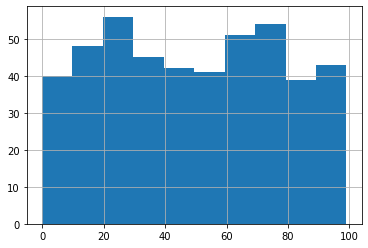

In [92]:
actual_v_predicted.rotten_scores.hist();

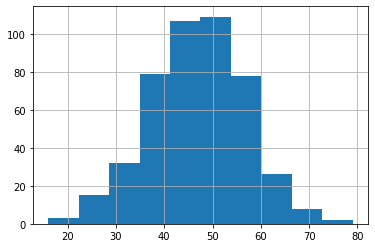

In [93]:
ax = actual_v_predicted.predicted_scores.hist();
ax.settitle

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



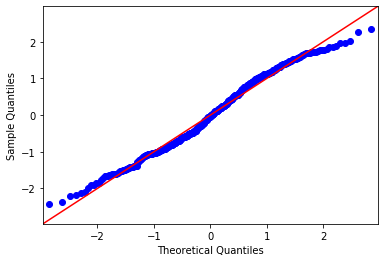

In [94]:
fig = sm.graphics.qqplot(test_residuals, dist=stats.norm, line='45', fit=True)
fig.show();

In [95]:
actual_v_predicted

,titles,rotten_scores,predicted_scores
655,a-cure-for-wellness,41,46
76,big-mommas-like-father-like-son,4,38
316,all-eyez-on-me,18,28
1352,pavarotti,86,61
572,state-like-sleep,35,49
921,despicable-me-3,57,43
757,goosebumps-2-haunted-halloween,47,37
1506,mcqueen,98,72
1344,come-to-daddy,86,40
1197,serendipity,76,44


### Features Only with XG Boost Regressor

Setting up all the features for a features-only (non-tfidf) regression model.

In [96]:
# Need to change this as the model chokes on the period.
rotten_model.rename(columns={'.':'PER'}, inplace=True)

# Dropping out the unnecessary columns.
to_drop = list(rotten_model.columns[:7])
to_drop.append(rotten_model.columns[9])
to_drop.extend(rotten_model.columns[19:22])
to_drop.extend(rotten_model.columns[-2:])

to_drop_2 = ['sentiment_compound', 'unique_words', 'X', 'JJ', 'NNP', 'DET',
             'semi_ratios', 'ADJ']

predictors_all = rotten_df_cut.copy()
predictors_all.drop(to_drop, axis=1, inplace=True)
predictors_all.drop(to_drop_2, axis=1,inplace=True)

# Adding dummy categories.
# rotten_dummies = pd.get_dummies(rotten_model['category'])
# predictors_all = pd.merge(predictors_all, rotten_dummies, left_index=True, 
#              right_index=True)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(predictors_all,
                                                    rotten_model.rotten_scores,
                                                    test_size=.3)

In [98]:
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), 
                          columns = X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), 
                            columns=X_test.columns)

In [99]:
scaled_y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
scaled_y_test = scaler.transform(np.array(y_test).reshape(-1,1))
scaled_y_train = pd.Series(scaled_y_train.reshape(-1,), name='rotten_scores')
scaled_y_test = pd.Series(scaled_y_test.reshape(-1,), name='rotten_scores')

In [100]:
scaled_X_train.fillna(0, inplace=True)
scaled_X_test.fillna(0, inplace=True)

In [101]:
def test(x):
    if x == 0:
        return math.log((X + 1) / 100)
    else:
        return math.log(x / 100)

In [102]:
model = XGBRegressor(random_state=42, n_estimators=100, 
                     objective='reg:squarederror')
model.fit(scaled_X_train, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Making predictions and calculating residuals

In [103]:
y_hat_train = model.predict(pd.DataFrame(scaled_X_train))
y_hat_test = model.predict(pd.DataFrame(scaled_X_test))

train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [104]:
print('Ave deviation from actual: ', round(sum(abs(test_residuals)) / len(test_residuals),2))

Ave deviation from actual:  23.25


In [105]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 339.5014011625739
Test Mean Squarred Error: 775.9880641716477


In [106]:
print('R^2 score:', r2_score(y_test,y_hat_test))

R^2 score: 0.06923286403294127


In [107]:
y_pred = model.predict(scaled_X_test)

Creating dataframe of predicted scores vs. actual

In [108]:
actual_v_predicted = X_test.copy()

pred_scores = list(y_pred)

actual_v_predicted['predicted_scores'] = pred_scores

to_merge = rotten_model[['titles', 'rotten_scores']]

actual_v_predicted = actual_v_predicted.merge(to_merge, left_index=True,
                                              right_index=True)

actual_v_predicted = actual_v_predicted[['titles','rotten_scores',
                                         'predicted_scores']]

actual_v_predicted['predicted_scores'] = actual_v_predicted.predicted_scores.\
    apply(lambda x: int(x))

actual_v_predicted = actual_v_predicted[actual_v_predicted['predicted_scores'] <= 100]

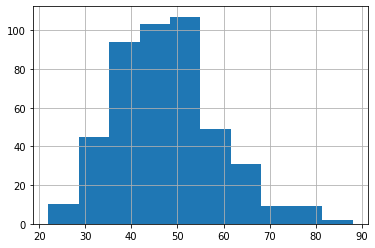

In [109]:
actual_v_predicted.predicted_scores.hist()

In [110]:
actual_v_predicted

,titles,rotten_scores,predicted_scores
459,bethany,28,41
224,sextuplets,13,39
678,what-men-want,42,49
174,vanishing-of-sidney-hall-the,10,51
1164,mercy-the,73,50
468,shock-and-awe,28,56
1106,paterno,69,52
138,rings,7,45
590,close,36,43
245,regression,14,41


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



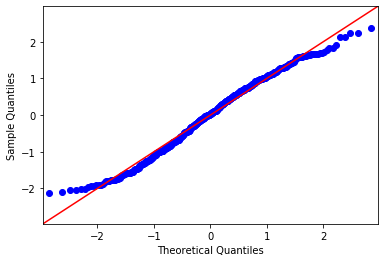

In [111]:
fig = sm.graphics.qqplot(test_residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### TFIDF with Features with XG Boost Regressor

In [112]:
X = predictors_all

In [113]:
tfidf = TfidfVectorizer(max_features=5000, max_df=.9, min_df=.1, 
                        ngram_range=(1,2))
X2 = tfidf.fit_transform(rotten_model.no_stop)

In [114]:
# Creating a sparse DataFrame to house both the features and the 
# processed text.
X_temp = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                           default_fill_value=0)
# Necessary for next step.
X = X.reset_index(drop=True)

# Combining text matrix with script attributes.
for column in X:
    X_temp[column] = X[column]
X = X_temp

In [115]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, random_state=42,
                                                    test_size=.3)

In [116]:
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), 
                          columns = X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), 
                            columns=X_test.columns)

In [117]:
scaled_y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
scaled_y_test = scaler.transform(np.array(y_test).reshape(-1,1))
scaled_y_train = pd.Series(scaled_y_train.reshape(-1,), name='rotten_scores')
scaled_y_test = pd.Series(scaled_y_test.reshape(-1,), name='rotten_scores')

In [118]:
scaled_X_train.fillna(0, inplace=True)
scaled_X_test.fillna(0, inplace=True)

In [119]:
def test(x):
    if x == 0:
        return math.log((X + 1) / 100)
    else:
        return math.log(x / 100)

In [120]:
model = XGBRegressor(random_state=42, n_estimators=100, 
                     objective='reg:squarederror')
model.fit(scaled_X_train, y_train)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [121]:
y_hat_train = model.predict(pd.DataFrame(scaled_X_train))
y_hat_test = model.predict(pd.DataFrame(scaled_X_test))

In [122]:
train_residuals = y_hat_train - list(y_train)
test_residuals = y_hat_test - list(y_test)

In [123]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.054401228515797505
Test Mean Squarred Error: 0.23082222104931627


In [124]:
print('r^2 score:', r2_score(y_test,y_hat_test))

r^2 score: 0.07667167249770279


Overall, the regression didn't work out that well. I probably could have done more with it with more time, and it would be interesting to get deeper into it. 

# Interpretation

Using the above attributes and more, I was able to create a predictive models that would ascertain whether a script was from a top-rated movie or a bottom-rated movie about 65% of the time. Within that models was some flexibility, however. Some models were better at predicting whether a movie would be 'good' (a true positive), while others were better at predicting whether a movie would be 'bad' (a true negative). The purpose of the prediction would dictate which model to employ.

Some recommendations on what can be done with this information:

Studios looking to cull out poor scripts from their stock should use the TFIDF with neural network model, which has an 81% rating for correctly predicting a bad scripts, and a 64% accuracy rating overall.

Filmmakers looking create the largest set of good scripts from the total should use the random boost with script attributes model, which has a 69% chance of correctly predicting a good script, though only a 55% accuracy score overall.

Filmmakers and screenwriters looking to find the most balanced filter for finding good screenplays and culling out the bad should look to the stacked model with support vector classifier using TFIDF followed by a random forest classifier using script attributes, which had the highest overall accuracy rate of 68%. If you're a screenwriter seeing your work coming up on the bad side, and especially if it contains a number of the "thumbs down" words noted above, you might want to start rethinking your life choices.


The scope of this idea is large, and there are numerous opportunities for further study. A few I would like to peruse are:

Using TFIDF on the word clouds to get a different, possibly more accurate take on what words are realistically more prevalent throughout a large body of texts.

Continue modeling with neural networks, especially with GloVe or other existing word embedding libraries.

Continue further work on regression analysis to predict no just whether a scripts is good or bad, but to predict the actual score it will receive on a scale of 0 to 100.

In the dashboard, provide a text entry or upload option where a script could be entered and a 'good' or 'bad' rating could be assigned, to easily determine where a given script might lie.

# Appendix: Functions

In [131]:
import inspect
txt = inspect.getsource(fun.hybrid_classifiers)
md ="```python\n"+ txt +"\n```"
Markdown(md)

```python
def hybrid_classifiers(X_train, X_test, y_train, y_test, classifier, 
                       cmap=plt.cm.Reds, use_tfidf=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model."""
    
    # Typical train test split to retain data for validation.
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=.3,
#                                                     random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
    
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
        
#     scaler = StandardScaler
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
#     X_test_scaled = scaler.transform(X_test)
    
    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X_resampled, y_resampled)
    
    # Creating predicted data.
    y_pred = pipe.predict(X_test)
    
    # Running metrics and creating a confusion matrix visual.
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass

    return y_pred

```

In [130]:
from IPython.display import display,Markdown
with open('functions.py','r') as f:
    txt = f.read()
md ="```python\n"+ txt +"\n```"
Markdown(md)

```python
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

nlp = spacy.load('en_core_web_sm')

def format_titles(title_list):
    """This function formats the movie titles in such a way that they can be
    discerned by the web site where the screenplays will be taken from.
    
    Parameter:
    
        title_list: list
        list of titles to be formatted, generally from metacritic.
        
    Returns: 
    
        list containing titles in the proper format for scraping screenplays from
        springfieldspringfield.co.uk."""
    
    # Initializing list for later
    titles_formatted = []
    
    # Will cycle through all titles and leave them in the correct format for
    # later use.
    for title in title_list:
        title = title.lower()
        
        # Titles on this site have ', the' at the end.
        if title[:3] == 'the':
            title = title[4:] + ', the'
        
        # Getting rid of punctuation that wouldn't be in the url.
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*~"""
        for x in title: 
            if x in punctuations: 
                title = title.replace(x, '')
        
        # In the url, the spaces are hyphens.
        for x in title:
            title = title.replace('  ', '-')
            title = title.replace(' ', '-')
            title = title.replace('_', '-')
            
        titles_formatted.append(title)

    return titles_formatted

def grab_screenplays(formatted_titles):
    """Function takes correctly formatted titles and scrapes the associated
    screenplays from http://www.springfieldspringfield.co.uk.
    
    Parameter:
    
        formatted_titles: list
            Takes titles formatted by the fomatted_titles function and 
            retrieves screenplays from springfieldspringfield.
 
     Returns:
         
         list containing screenplays from argument title list.
         
         list conaining list of movies for which screenplays could not be
         found."""
         
    # scrs will hold the screenplays themselves. errors will house the titles
    # of the movies we couldn't retrieve scripts for.
    scrs = {}
    errors = []
    
    for title in formatted_titles:
        print(title)
        
        # Beginning the web scraping by opening the connection to the site,
        # putting the title into the url, and and copying the html into local variables.
        # Note the titles are pre-formatted as word-word-word-the (if there is a 'the.'
        html_page = requests.get(
            'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(title))
        soup = BeautifulSoup(html_page.content, 'html.parser')
        
        # Getting the container for the screenplay.
        scr = soup.find('div', class_ = 'scrolling-script-container')
        
        # Several conditionals here to cycle through the various possibilities
        # of title formatting to find if there is a page at all.
        if scr:
            scr = scr.contents
        if not scr:
            
            # The formatting function puts 'the' at the end if there is one. 
            # Sometimes 'the' is simply removed. This will catch those.
            no_the = title[:-4]
            html_page = requests.get(
                'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(no_the))
            soup = BeautifulSoup(html_page.content, 'html.parser')
            scr = soup.find('div', class_ = 'scrolling-script-container')
            if scr:
                scr = scr.contents
                
            
        if not scr:
            
            # A few movies keep 'the' at the beginning. This will catch those.
            pre_the = 'the-' + title[:-4]
            html_page = requests.get(
                'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(pre_the))
            soup = BeautifulSoup(html_page.content, 'html.parser')
            scr = soup.find('div', class_ = 'scrolling-script-container')
            if scr:
                scr = scr.contents
                
            # If we still can't find the script, return a message that we couldn't
            # and put the title in an error list.
        if not scr:
            print('***The following screenplay could not be retrieved: ', title)
            errors.append(title)
        if scr:
            
            # Pulling out the unnecessary line html line breaks.
            scr = [i for i in scr if str(i) not in ['<br/>']] 
        scrs[title] = scr
        
        # Sleeping between each loop so the site server doesn't think we're 
        # trying to do anything malicious.
        time.sleep(1)
        
    return scrs, errors
    
def clean(word_list):
    """Combines each script into one long string and removes punctuation and
    html tags from the scripts. Note that this function is not always used,
    depending on what is needed from the data.
    
    Parameters:
    
        word_list: list
            List of words from one screenplay, usually in raw format
            
    Returns:
    
        A complete screenplay made of one long string with symbols and html
        breaks removed."""
    
    result = ''
    
    # Each line of the scipt is broken into a separate string. This combines
    # them into one long string.
    for line in word_list:
        result += str(line)
        
    # This removes the line breaks. They should have already been removed 
    # above but this is a backup.
    while '<br/>' in result:
        result = result.replace('<br/>', '')
        
    # Removing punctuations.
    punctuations = """!()-[]{};:"\,<>./?@#$%^&*_~"""
    for char in result: 
        if char in punctuations: 
            result = result.replace(char, '')
    
    return result

def script_classifiers(X, y, classifier, test_size=.3, cmap=plt.cm.Reds, use_tfidf=True,
                       use_split_resample=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model."""
    
    # Typical train test split to retain data for validation.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
        
#     scaler = StandardScaler
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
#     X_test_scaled = scaler.transform(X_test)

    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X_resampled, y_resampled)
    
    # Creating predicted data.
    y_pred = pipe.predict(X_test)
    
    # Running metrics and creating a confusion matrix visual.
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

def stacked_classifier(X, y, classifier, cmap=plt.cm.Reds, use_tfidf=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Used specifically to geenrate the first model for a stacked set.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
    Returns:
        numpy array of predictions."""
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
    
    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X, y)
    
    # Creating predicted data.
    y_pred = pipe.predict(X)
    
    # Running metrics and creating a confusion matrix visual of training data.
    print(classification_report(y, y_pred))

    confusion = confusion_matrix(y, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X)
        fpr, tpr, thresholds = roc_curve(y, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass

    return y_pred

def hybrid_classifiers(X_train, X_test, y_train, y_test, classifier, 
                       cmap=plt.cm.Reds, use_tfidf=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model."""
    
    # Typical train test split to retain data for validation.
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=.3,
#                                                     random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
    
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
        
#     scaler = StandardScaler
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
#     X_test_scaled = scaler.transform(X_test)
    
    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X_resampled, y_resampled)
    
    # Creating predicted data.
    y_pred = pipe.predict(X_test)
    
    # Running metrics and creating a confusion matrix visual.
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass

    return y_pred
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 


def ceci_nest_pas_une_pipe(X, y, text_to_vec, classifier, 
                           cmap=plt.cm.Reds):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot. As opposed with 
    the above 'script_classifiers' function, this one does not use a pipe,
    lending some additional flexibility between vectorization and modeling.
    Generally to be used with combining features and word vectors.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        text_to_vec: word vector matrix
            In addition to features, adds a word vector matrix to join with
            the other features for modeling.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot."""

#     if text_to_vec:
    # Putting the TfidfVectorizer up front so I can fiddle with things
    # before the classifier.
    tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                             ngram_range=(1,2))
    X2 = tfidf.fit_transform(text_to_vec)

    # Creating a sparse DataFrame to house both the features and the 
    # processed text.
    X_temp = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                               default_fill_value=0)

    # Necessary for next step.
    X = X.reset_index(drop=True)

    # Combining text matrix with script attributes.
    for column in X:
        X_temp[column] = X[column]
    X = X_temp
    
    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
   
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actually wants a series if its only one column.
    if type(X_resampled) == pd.core.series.Series:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Classifier can be whatever the user has entered as an argument. 
    clf = classifier
    clf.fit(X_resampled, y_resampled)
    
#     # The below is for creating the train scores.
#     y_train_pred = clf.predict(X_train)
    
#     # Printing out metrics and confusion matrix visual for training.
#     print(classification_report(y_train, y_train_pred))
#     print('Accuracy: ', accuracy_score(y_train, y_train_pred))

#     confusion = confusion_matrix(y_train, y_train_pred)
#     plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
#                   show_normed=True, cmap=cmap);
#     plt.show();
    
    # The below is for creating the test scores.
    y_pred = clf.predict(X_test)
    
    # Printing out metrics and confusion matrix visual for testing.
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = classifier.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
    if feature_importance:  
        try:
            print(pd.Series(clf.feature_importances_,
                      index=X_train.columns).sort_values(ascending=False).head(200))
            df_importance = pd.Series(clf.feature_importances_, 
                                      index=X_train.columns)
            df_imp_export = df_importance.sort_values(ascending=False)
            df_importance = df_importance.sort_values(ascending=True).tail(200)
        #         df_importance.index = [labels[x] for x,y in df_importance]
            df_importance.plot(kind='barh', figsize=(8,50))
            plt.title('Most Important Features')
            plt.ylabel('Feature Name')
            plt.xlabel('Feature Importance')
            plt.show()
        except: 
            pass
    
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

def hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                            y_train, y_test, classifier,
                            cmap=plt.cm.Reds, feature_importance=False):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot. As opposed with 
    the above 'script_classifiers' function, this one does not use a pipe,
    lending some additional flexibility between vectorization and modeling.
    Generally to be used with combining features and word vectors.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        text_to_vec: word vector matrix
            In addition to features, adds a word vector matrix to join with
            the other features for modeling.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot."""

#     if text_to_vec:
    # Putting the TfidfVectorizer up front so I can fiddle with things
    # before the classifier.
    tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                             ngram_range=(1,2))
    X2_train = tfidf.fit_transform(X2_train)
    X2_test = tfidf.transform(X2_test)    

    # Creating a sparse DataFrame to house both the features and the 
    # processed text.
    X_temp = pd.SparseDataFrame(X2_train, columns=tfidf.get_feature_names(),
                               default_fill_value=0)
                                                        
    X_temp2 = pd.SparseDataFrame(X2_test, columns=tfidf.get_feature_names(),
                               default_fill_value=0)
    
    # Necessary for next step.
#     X_train = X_train.reset_index(drop=True)
#     X_test = X_test.reset_index(drop=True)
    
    # Combining text matrix with script attributes.
    for column in X_train:
        X_temp[column] = X_train[column]
        X_temp2[column] = X_test[column]
    X_train = X_temp
    X_test = X_temp2

    # I really wish I knew why this was necessary. I really do. But for whatever
    # reason, I keep getting just a few null values at this point in the function.
    X_test.fillna(0,inplace=True)
    X_train.fillna(0,inplace=True)
    
#     temp = pd.DataFrame(X2_train, columns=['temp'])
#     display(X_train.iloc[[40, 69, 101, 106, 147, 175, 264, 303, 343, 371, 392,
#              464, 656, 811, 963, 1099, 2024, 2044, 2066, 2265, 2554,2560]])
    
    X_train.fillna(0,inplace=True)
    # Standard train-test split.
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=.3,
#                                                     random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
   
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
#     if type(X_resampled) == pd.core.series.Series:
#         X_resampled = X_resampled.iloc[:, 0]
    
    # Classifier can be whatever the user has entered as an argument. 
    clf = classifier
    clf.fit(X_resampled, y_resampled)
    
#     # The below is for creating the train scores.
#     y_train_pred = clf.predict(X_train)
    
#     # Printing out metrics and confusion matrix visual for training.
#     print(classification_report(y_train, y_train_pred))
#     print('Accuracy: ', accuracy_score(y_train, y_train_pred))

#     confusion = confusion_matrix(y_train, y_train_pred)
#     plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
#                   show_normed=True, cmap=cmap);
#     plt.show();

#     temp = pd.DataFrame(X_test, columns=['temp'])
#     print(temp[temp['temp'].isna() == True].index)

    # temp = X_test.CCONJ.isna() == True
    # display(temp)
    
    # The below is for creating the test scores.
    y_pred = clf.predict(X_test)
    
    # Printing out metrics and confusion matrix visual for testing.
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = classifier.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
    if feature_importance:  
        try:
            print(pd.Series(clf.feature_importances_,
                      index=X_train.columns).sort_values(ascending=False).head(200))
            df_importance = pd.Series(clf.feature_importances_, 
                                      index=X_train.columns)
            df_imp_export = df_importance.sort_values(ascending=False)
            df_importance = df_importance.sort_values(ascending=True).tail(200)
        #         df_importance.index = [labels[x] for x,y in df_importance]
            df_importance.plot(kind='barh', figsize=(8,50))
            plt.title('Most Important Features')
            plt.ylabel('Feature Name')
            plt.xlabel('Feature Importance')
            plt.show()
        except: 
            pass

def grid_search_a(X, y, classifier, param_grid, use_tfidf=True):
    """Performs a grid search to optimize parameters for classification models.
    
    Parameters:
    
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
        Returns:
            dictionary of best parameters."""

    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # Under-sampling to even out the field.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

    # If only one column, the classifier wants it as a series.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # User has a choice to use a tfidf classifier or not.
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
    
    # Performs a grid search and generates the best parameter set.
    grid_search = GridSearchCV(pipe, cv=None,
                               return_train_score=True, verbose=10,
                               scoring='accuracy', param_grid=param_grid,
                               n_jobs=-1)

    grid_search.fit(X_resampled, y_resampled)

    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)

    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)

    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_
            
def feature_graphics(df, col_start, col_end, add_columns=None, scatterdim=(1600,1600), 
                       figsize=(20,20), browser=False):
    """Creates scatter matrix, histograms, and corrolation matrix for 
    supplied dataframe and columns.
    
    Parameters:
        
        df: DataFrame
            DataFrame of movie information, probably from either rotten_df_cut
            or screenplays_cut.
            
        col_start: string
            Name of column in sequence to start with.
            
        col_end: string
            Name of column in sequence to end with.
            
        scatterdim: tuple
            dimensions in pixels for scatter matrix
            
        figsize: tuple
            dimensions in inches for histograms and hamburgers.
            
        browser: bool
            Indicates whether scatter matrix also opens in browser."""

    # Create subset DataFrame using start & end columns.
    temp = df[df.columns[\
        list(df.columns).index(col_start):list(df.columns)\
                                               .index(col_end)+1]].copy()
    
    # If the DataFrame is rotten_df_cut, we should add the rotten_scores column.
    temp['RottenScore'] = df.rotten_scores
    color = df.rotten_scores/100
    
    # Moving data to format Plotly will understand for scatter matrix.
    dimensions = []
    for column in temp.columns:
        dimensions.append({'label':column,'values':temp[column]})

    # Creating scatter matrix.
    data = [go.Splom(
        dimensions=dimensions,
        marker={'size':2,
                'color':color,
                'colorbar':{'thickness':20}
               }
    )]
    layout = go.Layout(height=scatterdim[1],
                       width=scatterdim[0])
    fig = go.Figure(data, layout)
    fig.show();   
    
    # Plotly can send the graph to a browser; useful for dashboards.
    if browser == True:
        pyo.plot(fig);
    
    # Create histogram of the same data.
    temp.hist(figsize=figsize);
    
    # Create corrolation heatmap of the same data.
    plt.subplots(figsize=figsize)
    sns.heatmap(temp.corr(), annot = True);
    
def stop_it(text, punct=False):
    """Removes stop words and punctuation.
    
    Arguments:
    
        text: string
            Text to have stop words and punctuation removed from..
            
        punct: bool
            If set to true, will also remove punctuation.
            
    Returns:
        String of words with stop words removed, and punctuation removed if
        selected."""
    
    text=text
    
    # Remove punctuation if indicated in arguments to do so.
    if punct == True:
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*_~"""
        for x in text: 
            if x in punctuations: 
                text = text.replace(x, '')
    
    # Split the string into a list of words to compare against the
    # spacy nlp.Defaults.stop_words list.
    split_it = text.split()
    stopped = [word.lower() for word in split_it \
               if word.lower() not in nlp.Defaults.stop_words]
    
    # Converting list back into a continuous string.
    last_word = ''
    for word in stopped:
        last_word += (' ' + word)
        
    return last_word
    
def cut_down_dist(data1, data2, std_level, label_1, label_2):
    std = data1.mean() \
        + data1.std()*std_level
    
    plot_info_1 = data1.drop(data1[lambda x: x > std].index)
    
    std2 = data2.mean() \
        + data2.std()*std_level
    
    plot_info_2 = data2.drop(data2[lambda x: x > std].index)

    fig = plt.figure(figsize=(10,8))
    sns.distplot(plot_info_1, label=label_1, bins=100, norm_hist=False)
    sns.distplot(plot_info_2, label=label_2, bins=100, norm_hist=False)
    plt.legend()
    plt.show();    

def top_words(words, max_features, min_df, max_df):
    """Takes in a series of documents and returns an ordered list of 
    how frequently words appear as calculated by sum vs count.
    
    Parameters:
    
        words: Series
            A series of documents with words to be counted.
            
        max_features: int
            Populates max_features value in vectorizer. Ceiling for how many
            words to use.
            
        min_df: float or int
            Populates min_df value in vectorizer. Minimum documents a word
            must appear in to be counted.
            
        max_df: float or int
            Populates max_df value in vectorizer. Maximum documents a word
            must appear in to be counted.
        
    returns: 
        List of tuples with word and ratio calculated by sum / count:
        (word, ratio), sorted by ratio."""
    
    # Initialize vectorizor and fit
    victor = CountVectorizer(max_features=max_features, 
                             min_df=min_df, max_df=max_df)
    movies_victor = victor.fit_transform(words)
    
    # Transform into SparceDataFrame.
    sdf = pd.SparseDataFrame(movies_victor, 
                                     columns=victor.get_feature_names())
    
    sdf.fillna(0, inplace=True)
    
    # Ave_word_count will house the tuples data to be sorted.
    ave_word_count = []
    for col in sdf.columns:
        key = col
        
        # Calculate the ratio and add tuple to list.
        value = sum(sdf[col]) / len(sdf[col])
        ave_word_count.append((key, value))
        
    # Return sorted tuple with word and ratio.
    return sorted(ave_word_count, key=lambda x: x[1], reverse=True)
```

```
def format_titles(title_list):
    """This function formats the movie titles in such a way that they can be
    discerned by the web site where the screenplays will be taken from.
    
    Parameter:
    
        title_list: list
        list of titles to be formatted, generally from metacritic.
        
    Returns: 
    
        list containing titles in the proper format for scraping screenplays from
        springfieldspringfield.co.uk."""
    
    # Initializing list for later
    titles_formatted = []
    
    # Will cycle through all titles and leave them in the correct format for
    # later use.
    for title in title_list:
        title = title.lower()
        
        # Titles on this site have ', the' at the end.
        if title[:3] == 'the':
            title = title[4:] + ', the'
        
        # Getting rid of punctuation that wouldn't be in the url.
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*~"""
        for x in title: 
            if x in punctuations: 
                title = title.replace(x, '')
        
        # In the url, the spaces are hyphens.
        for x in title:
            title = title.replace('  ', '-')
            title = title.replace(' ', '-')
            title = title.replace('_', '-')
            
        titles_formatted.append(title)

    return titles_formatted

def grab_screenplays(formatted_titles):
    """Function takes correctly formatted titles and scrapes the associated
    screenplays from http://www.springfieldspringfield.co.uk.
    
    Parameter:
    
        formatted_titles: list
            Takes titles formatted by the fomatted_titles function and 
            retrieves screenplays from springfieldspringfield.
 
     Returns:
         
         list containing screenplays from argument title list.
         
         list conaining list of movies for which screenplays could not be
         found."""
         
    # scrs will hold the screenplays themselves. errors will house the titles
    # of the movies we couldn't retrieve scripts for.
    scrs = {}
    errors = []
    
    for title in formatted_titles:
        print(title)
        
        # Beginning the web scraping by opening the connection to the site,
        # putting the title into the url, and and copying the html into local variables.
        # Note the titles are pre-formatted as word-word-word-the (if there is a 'the.'
        html_page = requests.get(
            'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(title))
        soup = BeautifulSoup(html_page.content, 'html.parser')
        
        # Getting the container for the screenplay.
        scr = soup.find('div', class_ = 'scrolling-script-container')
        
        # Several conditionals here to cycle through the various possibilities
        # of title formatting to find if there is a page at all.
        if scr:
            scr = scr.contents
        if not scr:
            
            # The formatting function puts 'the' at the end if there is one. 
            # Sometimes 'the' is simply removed. This will catch those.
            no_the = title[:-4]
            html_page = requests.get(
                'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(no_the))
            soup = BeautifulSoup(html_page.content, 'html.parser')
            scr = soup.find('div', class_ = 'scrolling-script-container')
            if scr:
                scr = scr.contents
                
            
        if not scr:
            
            # A few movies keep 'the' at the beginning. This will catch those.
            pre_the = 'the-' + title[:-4]
            html_page = requests.get(
                'https://www.springfieldspringfield.co.uk/movie_script.php?movie={}'.format(pre_the))
            soup = BeautifulSoup(html_page.content, 'html.parser')
            scr = soup.find('div', class_ = 'scrolling-script-container')
            if scr:
                scr = scr.contents
                
            # If we still can't find the script, return a message that we couldn't
            # and put the title in an error list.
        if not scr:
            print('***The following screenplay could not be retrieved: ', title)
            errors.append(title)
        if scr:
            
            # Pulling out the unnecessary line html line breaks.
            scr = [i for i in scr if str(i) not in ['<br/>']] 
        scrs[title] = scr
        
        # Sleeping between each loop so the site server doesn't think we're 
        # trying to do anything malicious.
        time.sleep(1)
        
    return scrs, errors
    
def clean(word_list):
    """Combines each script into one long string and removes punctuation and
    html tags from the scripts. Note that this function is not always used,
    depending on what is needed from the data.
    
    Parameters:
    
        word_list: list
            List of words from one screenplay, usually in raw format
            
    Returns:
    
        A complete screenplay made of one long string with symbols and html
        breaks removed."""
    
    result = ''
    
    # Each line of the scipt is broken into a separate string. This combines
    # them into one long string.
    for line in word_list:
        result += str(line)
        
    # This removes the line breaks. They should have already been removed 
    # above but this is a backup.
    while '<br/>' in result:
        result = result.replace('<br/>', '')
        
    # Removing punctuations.
    punctuations = """!()-[]{};:"\,<>./?@#$%^&*_~"""
    for char in result: 
        if char in punctuations: 
            result = result.replace(char, '')
    
    return result

def script_classifiers(X, y, classifier, test_size=.3, cmap=plt.cm.Reds, use_tfidf=True,
                       use_split_resample=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model."""
    
    # Typical train test split to retain data for validation.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
        
#     scaler = StandardScaler
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
#     X_test_scaled = scaler.transform(X_test)

    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X_resampled, y_resampled)
    
    # Creating predicted data.
    y_pred = pipe.predict(X_test)
    
    # Running metrics and creating a confusion matrix visual.
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

def stacked_classifier(X, y, classifier, cmap=plt.cm.Reds, use_tfidf=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Used specifically to geenrate the first model for a stacked set.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
    Returns:
        numpy array of predictions."""
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
    
    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X, y)
    
    # Creating predicted data.
    y_pred = pipe.predict(X)
    
    # Running metrics and creating a confusion matrix visual of training data.
    print(classification_report(y, y_pred))

    confusion = confusion_matrix(y, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X)
        fpr, tpr, thresholds = roc_curve(y, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass

    return y_pred

def hybrid_classifiers(X_train, X_test, y_train, y_test, classifier, 
                       cmap=plt.cm.Reds, use_tfidf=True):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model."""
    
    # Typical train test split to retain data for validation.
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=.3,
#                                                     random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
    
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Provides the option of using tfidf in case this is just using scripts 
    # attributes and not text embedding or vectorization
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        
        # These tfidf hyper-parameters have been tested via grid-search
        # elsewhere and found to be optimal.
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
        
#     scaler = StandardScaler
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
#     X_test_scaled = scaler.transform(X_test)
    
    # Fitting the pipeline containing the tfidf processor and classifier.
    pipe.fit(X_resampled, y_resampled)
    
    # Creating predicted data.
    y_pred = pipe.predict(X_test)
    
    # Running metrics and creating a confusion matrix visual.
    print(classification_report(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = pipe.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass

    return y_pred
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 


def ceci_nest_pas_une_pipe(X, y, text_to_vec, classifier, 
                           cmap=plt.cm.Reds):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot. As opposed with 
    the above 'script_classifiers' function, this one does not use a pipe,
    lending some additional flexibility between vectorization and modeling.
    Generally to be used with combining features and word vectors.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        text_to_vec: word vector matrix
            In addition to features, adds a word vector matrix to join with
            the other features for modeling.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot."""

#     if text_to_vec:
    # Putting the TfidfVectorizer up front so I can fiddle with things
    # before the classifier.
    tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                             ngram_range=(1,2))
    X2 = tfidf.fit_transform(text_to_vec)

    # Creating a sparse DataFrame to house both the features and the 
    # processed text.
    X_temp = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                               default_fill_value=0)

    # Necessary for next step.
    X = X.reset_index(drop=True)

    # Combining text matrix with script attributes.
    for column in X:
        X_temp[column] = X[column]
    X = X_temp
    
    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
   
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actually wants a series if its only one column.
    if type(X_resampled) == pd.core.series.Series:
        X_resampled = X_resampled.iloc[:, 0]
    
    # Classifier can be whatever the user has entered as an argument. 
    clf = classifier
    clf.fit(X_resampled, y_resampled)
    
#     # The below is for creating the train scores.
#     y_train_pred = clf.predict(X_train)
    
#     # Printing out metrics and confusion matrix visual for training.
#     print(classification_report(y_train, y_train_pred))
#     print('Accuracy: ', accuracy_score(y_train, y_train_pred))

#     confusion = confusion_matrix(y_train, y_train_pred)
#     plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
#                   show_normed=True, cmap=cmap);
#     plt.show();
    
    # The below is for creating the test scores.
    y_pred = clf.predict(X_test)
    
    # Printing out metrics and confusion matrix visual for testing.
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = classifier.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
    if feature_importance:  
        try:
            print(pd.Series(clf.feature_importances_,
                      index=X_train.columns).sort_values(ascending=False).head(200))
            df_importance = pd.Series(clf.feature_importances_, 
                                      index=X_train.columns)
            df_imp_export = df_importance.sort_values(ascending=False)
            df_importance = df_importance.sort_values(ascending=True).tail(200)
        #         df_importance.index = [labels[x] for x,y in df_importance]
            df_importance.plot(kind='barh', figsize=(8,50))
            plt.title('Most Important Features')
            plt.ylabel('Feature Name')
            plt.xlabel('Feature Importance')
            plt.show()
        except: 
            pass
    
    
#     # Creating a decision tree classifier tree graph because it's cool.
# #     if classifier == DecisionTreeClassifier():
#     dot_data = export_graphviz(classifier, out_file=None, 
# #                                    feature_names=X.columns, 
#                                class_names=np.unique(y).astype('str'), 
#                                filled=True, rounded=True, 
#                                special_characters=True)

#     # Draw graph
#     graph = graph_from_dot_data(dot_data)  
#     # Show graph
#     Image(graph.create_png()) 
#     return Image(graph.create_png()) 

def hybrid_classifier_combo(X_train, X_test, X2_train, X2_test,
                            y_train, y_test, classifier,
                            cmap=plt.cm.Reds, feature_importance=False):
    """This function takes in values for a classifier and runs them through
    a pipe. Generates scores and a confusion matrix plot. As opposed with 
    the above 'script_classifiers' function, this one does not use a pipe,
    lending some additional flexibility between vectorization and modeling.
    Generally to be used with combining features and word vectors.
    
    Parameters:
        
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        text_to_vec: word vector matrix
            In addition to features, adds a word vector matrix to join with
            the other features for modeling.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot."""

#     if text_to_vec:
    # Putting the TfidfVectorizer up front so I can fiddle with things
    # before the classifier.
    tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                             ngram_range=(1,2))
    X2_train = tfidf.fit_transform(X2_train)
    X2_test = tfidf.transform(X2_test)    

    # Creating a sparse DataFrame to house both the features and the 
    # processed text.
    X_temp = pd.SparseDataFrame(X2_train, columns=tfidf.get_feature_names(),
                               default_fill_value=0)
                                                        
    X_temp2 = pd.SparseDataFrame(X2_test, columns=tfidf.get_feature_names(),
                               default_fill_value=0)
    
    # Necessary for next step.
#     X_train = X_train.reset_index(drop=True)
#     X_test = X_test.reset_index(drop=True)
    
    # Combining text matrix with script attributes.
    for column in X_train:
        X_temp[column] = X_train[column]
        X_temp2[column] = X_test[column]
    X_train = X_temp
    X_test = X_temp2

    # I really wish I knew why this was necessary. I really do. But for whatever
    # reason, I keep getting just a few null values at this point in the function.
    X_test.fillna(0,inplace=True)
    X_train.fillna(0,inplace=True)
    
#     temp = pd.DataFrame(X2_train, columns=['temp'])
#     display(X_train.iloc[[40, 69, 101, 106, 147, 175, 264, 303, 343, 371, 392,
#              464, 656, 811, 963, 1099, 2024, 2044, 2066, 2265, 2554,2560]])
    
    X_train.fillna(0,inplace=True)
    # Standard train-test split.
#     X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=.3,
#                                                     random_state=42)
    
    # There a few more bad scripts than good ones, so I'll make them even.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)
   
    # This is necessary for putting X into the correct format if there is only 
    # one column, as it comes out of the resampler a DataFrame when the
    # classifier actuallyl wants a series if its only one column.
#     if type(X_resampled) == pd.core.series.Series:
#         X_resampled = X_resampled.iloc[:, 0]
    
    # Classifier can be whatever the user has entered as an argument. 
    clf = classifier
    clf.fit(X_resampled, y_resampled)
    
#     # The below is for creating the train scores.
#     y_train_pred = clf.predict(X_train)
    
#     # Printing out metrics and confusion matrix visual for training.
#     print(classification_report(y_train, y_train_pred))
#     print('Accuracy: ', accuracy_score(y_train, y_train_pred))

#     confusion = confusion_matrix(y_train, y_train_pred)
#     plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
#                   show_normed=True, cmap=cmap);
#     plt.show();

#     temp = pd.DataFrame(X_test, columns=['temp'])
#     print(temp[temp['temp'].isna() == True].index)

    # temp = X_test.CCONJ.isna() == True
    # display(temp)
    
    # The below is for creating the test scores.
    y_pred = clf.predict(X_test)
    
    # Printing out metrics and confusion matrix visual for testing.
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, figsize=(7,7), colorbar=True,
                      show_normed=True, cmap=cmap);
    plt.show();
    
    # If there is a decision function in this classifier, we'll use it 
    # to create an ROC AUC graph.
    try:
        y_score = classifier.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print('roc_auc score: ', roc_auc)

        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show();
    except:
        pass
    
    if feature_importance:  
        try:
            print(pd.Series(clf.feature_importances_,
                      index=X_train.columns).sort_values(ascending=False).head(200))
            df_importance = pd.Series(clf.feature_importances_, 
                                      index=X_train.columns)
            df_imp_export = df_importance.sort_values(ascending=False)
            df_importance = df_importance.sort_values(ascending=True).tail(200)
        #         df_importance.index = [labels[x] for x,y in df_importance]
            df_importance.plot(kind='barh', figsize=(8,50))
            plt.title('Most Important Features')
            plt.ylabel('Feature Name')
            plt.xlabel('Feature Importance')
            plt.show()
        except: 
            pass

def grid_search_a(X, y, classifier, param_grid, use_tfidf=True):
    """Performs a grid search to optimize parameters for classification models.
    
    Parameters:
    
        X: DataFrame
            Features and values to be used in model.
            
        y: Series
            Target variable for classifying.
            
        Classifier: Classifier
            Which classifier to be used for training the model.
        
        cmap: pyplot color map
            Which color map to use for the confusion matrix plot.
            
        use_tfidf: bool
            Whether to use tfidf on feature data prior to running model.
            
        Returns:
            dictionary of best parameters."""

    # Standard train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=42)
    
    # Under-sampling to even out the field.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

    # If only one column, the classifier wants it as a series.
    if len(X_resampled.columns) < 2:
        X_resampled = X_resampled.iloc[:, 0]
    
    # User has a choice to use a tfidf classifier or not.
    if use_tfidf == False:
        pipe = Pipeline([('clf', classifier)])
    else:
        pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=.95, min_df=.1,
                                                  max_features=5000,
                                                  ngram_range=(1,2))), 
                         ('clf', classifier)])
    
    # Performs a grid search and generates the best parameter set.
    grid_search = GridSearchCV(pipe, cv=None,
                               return_train_score=True, verbose=10,
                               scoring='accuracy', param_grid=param_grid,
                               n_jobs=-1)

    grid_search.fit(X_resampled, y_resampled)

    # Create mean training and test scores.
    training_score = np.mean(grid_search.cv_results_['mean_train_score'])
    testing_score = grid_search.score(X_test, y_test)

    # Spit out the results.
    print(f"Mean Training Score: {training_score :.2%}")
    print(f"Mean Test Score: {testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    print(grid_search.best_params_)

    # Return the parameters so they can be seen and contemplated.
    return grid_search.best_params_
            
def feature_graphics(df, col_start, col_end, add_columns=None, scatterdim=(1600,1600), 
                       figsize=(20,20), browser=False):
    """Creates scatter matrix, histograms, and corrolation matrix for 
    supplied dataframe and columns.
    
    Parameters:
        
        df: DataFrame
            DataFrame of movie information, probably from either rotten_df_cut
            or screenplays_cut.
            
        col_start: string
            Name of column in sequence to start with.
            
        col_end: string
            Name of column in sequence to end with.
            
        scatterdim: tuple
            dimensions in pixels for scatter matrix
            
        figsize: tuple
            dimensions in inches for histograms and hamburgers.
            
        browser: bool
            Indicates whether scatter matrix also opens in browser."""

    # Create subset DataFrame using start & end columns.
    temp = df[df.columns[\
        list(df.columns).index(col_start):list(df.columns)\
                                               .index(col_end)+1]].copy()
    
    # If the DataFrame is rotten_df_cut, we should add the rotten_scores column.
    temp['RottenScore'] = df.rotten_scores
    color = df.rotten_scores/100
    
    # Moving data to format Plotly will understand for scatter matrix.
    dimensions = []
    for column in temp.columns:
        dimensions.append({'label':column,'values':temp[column]})

    # Creating scatter matrix.
    data = [go.Splom(
        dimensions=dimensions,
        marker={'size':2,
                'color':color,
                'colorbar':{'thickness':20}
               }
    )]
    layout = go.Layout(height=scatterdim[1],
                       width=scatterdim[0])
    fig = go.Figure(data, layout)
    fig.show();   
    
    # Plotly can send the graph to a browser; useful for dashboards.
    if browser == True:
        pyo.plot(fig);
    
    # Create histogram of the same data.
    temp.hist(figsize=figsize);
    
    # Create corrolation heatmap of the same data.
    plt.subplots(figsize=figsize)
    sns.heatmap(temp.corr(), annot = True);
    
def stop_it(text, punct=False):
    """Removes stop words and punctuation.
    
    Arguments:
    
        text: string
            Text to have stop words and punctuation removed from..
            
        punct: bool
            If set to true, will also remove punctuation.
            
    Returns:
        String of words with stop words removed, and punctuation removed if
        selected."""
    
    text=text
    
    # Remove punctuation if indicated in arguments to do so.
    if punct == True:
        punctuations = """!()-[]{};:'"\,<>./?@#$%^&*_~"""
        for x in text: 
            if x in punctuations: 
                text = text.replace(x, '')
    
    # Split the string into a list of words to compare against the
    # spacy nlp.Defaults.stop_words list.
    split_it = text.split()
    stopped = [word.lower() for word in split_it \
               if word.lower() not in nlp.Defaults.stop_words]
    
    # Converting list back into a continuous string.
    last_word = ''
    for word in stopped:
        last_word += (' ' + word)
        
    return last_word
    
def cut_down_dist(data1, data2, std_level, label_1, label_2):
    std = data1.mean() \
        + data1.std()*std_level
    
    plot_info_1 = data1.drop(data1[lambda x: x > std].index)
    
    std2 = data2.mean() \
        + data2.std()*std_level
    
    plot_info_2 = data2.drop(data2[lambda x: x > std].index)

    fig = plt.figure(figsize=(10,8))
    sns.distplot(plot_info_1, label=label_1, bins=100, norm_hist=False)
    sns.distplot(plot_info_2, label=label_2, bins=100, norm_hist=False)
    plt.legend()
    plt.show();    

def top_words(words, max_features, min_df, max_df):
    """Takes in a series of documents and returns an ordered list of 
    how frequently words appear as calculated by sum vs count.
    
    Parameters:
    
        words: Series
            A series of documents with words to be counted.
            
        max_features: int
            Populates max_features value in vectorizer. Ceiling for how many
            words to use.
            
        min_df: float or int
            Populates min_df value in vectorizer. Minimum documents a word
            must appear in to be counted.
            
        max_df: float or int
            Populates max_df value in vectorizer. Maximum documents a word
            must appear in to be counted.
        
    returns: 
        List of tuples with word and ratio calculated by sum / count:
        (word, ratio), sorted by ratio."""
    
    # Initialize vectorizor and fit
    victor = CountVectorizer(max_features=max_features, 
                             min_df=min_df, max_df=max_df)
    movies_victor = victor.fit_transform(words)
    
    # Transform into SparceDataFrame.
    sdf = pd.SparseDataFrame(movies_victor, 
                                     columns=victor.get_feature_names())
    
    sdf.fillna(0, inplace=True)
    
    # Ave_word_count will house the tuples data to be sorted.
    ave_word_count = []
    for col in sdf.columns:
        key = col
        
        # Calculate the ratio and add tuple to list.
        value = sum(sdf[col]) / len(sdf[col])
        ave_word_count.append((key, value))
        
    # Return sorted tuple with word and ratio.
    return sorted(ave_word_count, key=lambda x: x[1], reverse=True)
    ```